In [17]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dataset = pd.read_csv("tripadvisor_hotel_reviews.csv", delimiter=',', quoting=0)
dataset.head(10)

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
5,love monaco staff husband stayed hotel crazy w...,5
6,"cozy stay rainy city, husband spent 7 nights m...",5
7,"excellent staff, housekeeping quality hotel ch...",4
8,"hotel stayed hotel monaco cruise, rooms genero...",5
9,excellent stayed hotel monaco past w/e delight...,5


In [2]:
# to convert ratings into positive (1) and negative (0) 

def new_rating(Rating):
    if Rating in [1,2,3]:
        return 0
    elif Rating in [4,5]:
        return 1

dataset['Sentiment'] = dataset['Rating'].map(new_rating)
dataset.head(10)

,Review,Rating,Sentiment
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,0
3,"unique, great stay, wonderful time hotel monac...",5,1
4,"great stay great stay, went seahawk game aweso...",5,1
5,love monaco staff husband stayed hotel crazy w...,5,1
6,"cozy stay rainy city, husband spent 7 nights m...",5,1
7,"excellent staff, housekeeping quality hotel ch...",4,1
8,"hotel stayed hotel monaco cruise, rooms genero...",5,1
9,excellent stayed hotel monaco past w/e delight...,5,1


In [3]:
dataset["Sentiment"].value_counts()

Sentiment
1    15093
0     5398
Name: count, dtype: int64

In [8]:
import re  #regular expressions: functions for text manipulation like search, replace etc.
import nltk # natural language tool kit
nltk.download('stopwords')

from nltk.stem.porter import PorterStemmer # for stemming words, removing 'ing' etc.
ps = PorterStemmer()

from nltk.corpus import stopwords

all_stopwords = stopwords.words('english')
all_stopwords.remove('not')
all_stopwords.remove("won't")
all_stopwords.remove('no')
all_stopwords.remove('but')

corpus = []

for i in range(0,20491):
    review = re.sub('[^a-zA-Z]', ' ', dataset['Review'][i]) # substitutes with a replacement
    review = review.lower() #lowercases
    review = review.split() # tokenization of words
    review = [ps.stem(word) for word in review if word not in set(all_stopwords)] # stems all words which are not stopwords
    review = ' '.join(review) # joins all elements of a list in each row.
    corpus.append(review) # joins all the rows


[nltk_data] Downloading package stopwords to /home/naaz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


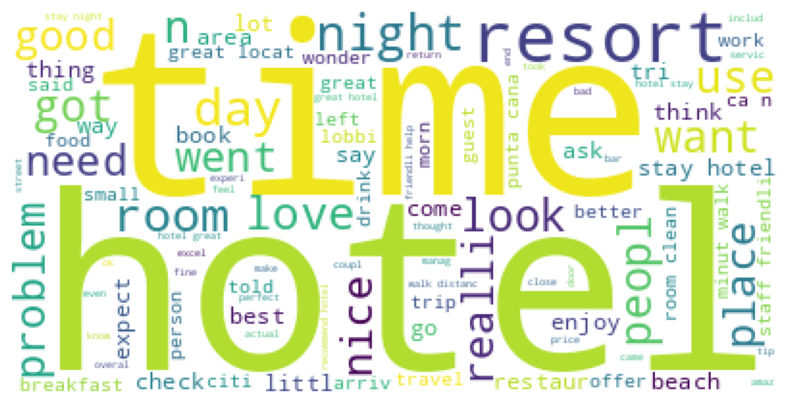

In [9]:
# lets create a wordcloud 

from PIL import Image #Python Imaging Library
from wordcloud import WordCloud

corpus_text = ' '.join(corpus)

wc = WordCloud(background_color="white")

wordcloud = wc.generate(corpus_text)

plt.figure(figsize=(10, 5))       
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('wordcloud.png', dpi=300, bbox_inches='tight', facecolor='white')


In [10]:
# Use TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(max_features=1500)

X = tf.fit_transform(corpus).toarray()
y = dataset["Sentiment"]

In [12]:
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

models = [MultinomialNB(), SVC(C=1., kernel='rbf'), RandomForestClassifier()] 

accuracy = []

for model in models:
    model.fit(X_train,y_train)
    acc = model.score(X_test,y_test)
    accuracy.append(acc)
            
print(accuracy) 

[0.8519151012442059, 0.898511832154184, 0.8619175408636253]


In [13]:
# Cross validation

from sklearn.model_selection import cross_val_score

models = [MultinomialNB(), SVC(C=1., kernel='rbf'), RandomForestClassifier()]  

best_accuracy = 0 # just to initiate
cross_val = []

for model in models:
    cross_score = cross_val_score(model, X_train, y_train, cv=5) 
    mean_cross_score = np.mean(cross_score)
    if mean_cross_score > best_accuracy:
        best_accuracy = mean_cross_score
        best_model = model

print(f'Best model: {best_model}')
print(f'Accuracy with 5-fold cross-validation: {best_accuracy}')

Best model: SVC()
Accuracy with 5-fold cross-validation: 0.9022084814694281


In [14]:
#training the best model

final_model = SVC(C=1., kernel='rbf')
final_model.fit(X_train, y_train) # trained

SVC()

In [15]:
import joblib

joblib.dump(final_model, 'SVC_model.joblib')
joblib.dump(tf, 'tfidf.joblib')

loaded_model = joblib.load('SVC_model.joblib')
loaded_vectorizer = joblib.load('tfidf.joblib')

In [16]:
# making predictions on new data

new_review = loaded_vectorizer.transform(['the food was good and the room was clean'])
new_review_dense = new_review.toarray()
predictions = loaded_model.predict(new_review_dense)

if predictions == 0:
    print('negative sentiment')
else:
    print('positive sentiment')

positive sentiment
